<a href="https://colab.research.google.com/github/a-maksimov/data_analysis/blob/main/imdb_horror_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Defining the questions
Q.1   Analyze which genres have the highest and the lowest average rating

Q.2   Analyze genre combinations make a successful

# Collecting and cleaning the data

IMDb Dataset:
https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset

title.basics.tsv.gz - Contains the following information for titles:
* tconst (string) - alphanumeric unique identifier of the title.
* titleType (string) – the type/format of the title (e.g. movie, short,
tvseries, tvepisode, video, etc).
* genres (string array) – includes up to three genres associated with
the title.

https://drive.google.com/file/d/1zys9QZjgjA_6kSg9EWd5RdNAJ13lDs2p/view?usp=sharing

title.ratings.tsv.gz – Contains the IMDb rating and votes information for titles:
* tconst (string) - alphanumeric unique identifier of the title.
* averageRating – weighted average of all the individual user ratings.
* numVotes - number of votes the title has received.

https://drive.google.com/file/d/1cszDgIoziE05bgcTN4oYDLWqDEWCWfPv/view?usp=sharing

In [78]:
! gdown 1zys9QZjgjA_6kSg9EWd5RdNAJ13lDs2p

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1zys9QZjgjA_6kSg9EWd5RdNAJ13lDs2p 



"basics" table is over 100 MB, so it can't be download with gdown. You have to mount Google Drive into notebook.

In [79]:
! unzip -o /content/drive/MyDrive/Datasets/title_basics.zip

Archive:  /content/drive/MyDrive/Datasets/title_basics.zip
  inflating: title_basics.tsv        


In [80]:
! gdown 1cszDgIoziE05bgcTN4oYDLWqDEWCWfPv

Downloading...
From: https://drive.google.com/uc?id=1cszDgIoziE05bgcTN4oYDLWqDEWCWfPv
To: /content/title_ratings.zip
100% 6.47M/6.47M [00:00<00:00, 163MB/s]


In [81]:
! unzip -o /content/title_ratings.zip

Archive:  /content/title_ratings.zip
  inflating: title_ratings.tsv       


In [82]:
import pandas as pd
import seaborn as sns

Parse the files.

From basics we keep only movies and relevant fields.

In [83]:
fields = ['tconst', 'titleType', 'primaryTitle',  'startYear', 'genres']
basics = pd.read_table('/content/title_basics.tsv', usecols=fields)[lambda row: row['titleType'] == 'movie']     

In [84]:
basics.head()

,tconst,titleType,primaryTitle,startYear,genres
8,tt0000009,movie,Miss Jerry,1894,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,1897,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,1905,\N
570,tt0000574,movie,The Story of the Kelly Gang,1906,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,1907,Drama


Parse ratings table

In [85]:
ratings = pd.read_table('/content/title_ratings.tsv')    

In [86]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1949
1,tt0000002,5.8,264
2,tt0000003,6.5,1782
3,tt0000004,5.6,179
4,tt0000005,6.2,2583


# Process

Merge "basics" table with "ratings" table into one "df" table

In [114]:
df = basics.merge(ratings, on='tconst', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 635049 entries, 0 to 635048
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   tconst         635049 non-null  object 
 1   titleType      635049 non-null  object 
 2   primaryTitle   635049 non-null  object 
 3   startYear      635049 non-null  object 
 4   genres         635049 non-null  object 
 5   averageRating  286871 non-null  float64
 6   numVotes       286871 non-null  float64
dtypes: float64(2), object(5)
memory usage: 38.8+ MB


Remove rows without genres or with votes no less than 1000 (from ~635k titles down to ~39k).

In [115]:
min_numVotes = 1000
df = df[(df['genres'] != r'\N') & (df['numVotes'] >= min_numVotes)].copy()

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39236 entries, 132 to 635040
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         39236 non-null  object 
 1   titleType      39236 non-null  object 
 2   primaryTitle   39236 non-null  object 
 3   startYear      39236 non-null  object 
 4   genres         39236 non-null  object 
 5   averageRating  39236 non-null  float64
 6   numVotes       39236 non-null  float64
dtypes: float64(2), object(5)
memory usage: 2.4+ MB


No we check genres combinations in order to define broader categories.

In [90]:
df.genres.value_counts().head()

Drama                   3070
Comedy                  1912
Comedy,Drama            1777
Drama,Romance           1592
Comedy,Drama,Romance    1500
Name: genres, dtype: int64

Genres is a string of maximum of 3 genres associated with the title.

For our analysis we map broader genre definitions in the following order:

1. Animation
2. Documentary
3. Musical
4. Comedy
5. Horror
6. Action
7. Adventure
8. Thriller
9. Crime
10. Drama
11. Other

[IMDB genre definitions](https://help.imdb.com/article/contribution/titles/genres/GZDRMS6R742JRGAG)

In [91]:
#@title Genres processing

# Returns the genre in the order of genres_order
def get_genre(string):
    string_list = string.split(',')
    genres_order = ['Animation', 'Documentary', 'Musical', 'Comedy', 'Horror', 'Action', 'Adventure',
                    'Thriller', 'Crime', 'Drama']
    if len(string_list) == 1:
        if string_list[0] in genres_order:
            return string_list[0]
        else:
            return 'Other'
    for genre in genres_order:
        if genre in string_list:
            return genre
    return 'Other'

In [92]:
df['genre'] = df['genres'].map(lambda genre: get_genre(genre))

In [93]:
df.genre.value_counts(dropna=False)

Comedy         12303
Drama           7982
Action          4771
Horror          4317
Thriller        2705
Documentary     1948
Crime           1787
Animation       1281
Adventure        996
Musical          669
Other            477
Name: genre, dtype: int64

We check which of genres combinations have NaN in "genre" column. Should be empty table.

In [94]:
df[df['genre'].isna()].groupby('genres')['tconst'].count().reset_index(name='count').sort_values(['count'], ascending=False)

,genres,count


# Q.1 Analysis
The formula for calculating the Top Rated 250 Titles gives a true Bayesian estimate weighted rating:
 
 
\begin{equation}
\text{WR} = \frac{v}{v+m} \times R + \frac{m}{v+m} \times C 
\end{equation}

Where:

$R$ = average for the movie (mean) = (averageRating)

$v$ = number of votes for the movie = (numVotes)

$m$ = minimum votes required to be listed in the Top 250 (currently 25000)

$C$ = the mean vote across the whole report (currently 7.0)

For the Top 250, only votes from regular voters are considered.

Since IMDb doesn't disclose who are regular voters, we can't really know what is the exact criteria.

[Source](https://www.quora.com/What-algorithm-does-IMDB-use-to-decide-the-top-250-movies)

We use this formula, however we calculate mean "averageRating" across whole df and minimum numVotes is 1000.

In [95]:
df['wr'] = ((df['numVotes'] / (df['numVotes'] + min_numVotes)) * df['averageRating']) + ((min_numVotes / (df['numVotes'] + min_numVotes)) * df['averageRating'].mean())

In [96]:
df.groupby('genre')['wr'].agg(['count', 'mean', 'min', 'max', 'std']).sort_values(['mean'], ascending=False)

,count,mean,min,max,std
genre,,,,,
Documentary,1948,6.967635,1.660355,9.305783,0.653643
Drama,7982,6.655169,1.070484,9.298876,0.714822
Crime,1787,6.638159,1.859680,9.198434,0.708101
Animation,1281,6.592325,1.706592,8.898109,0.842652
Musical,669,6.495156,2.058397,8.555974,0.807559
Adventure,996,6.399256,1.978464,8.989019,0.814355
Thriller,2705,6.287342,1.324256,8.903476,0.839034
Comedy,12303,6.209464,1.131240,9.130578,0.863136
Other,477,6.201415,2.618764,8.493304,0.889967


In [97]:
result = df.groupby('genre')['wr'].agg(['mean']).sort_values(['mean']).copy()
result

,mean
genre,
Horror,5.571763
Action,6.130389
Other,6.201415
Comedy,6.209464
Thriller,6.287342
Adventure,6.399256
Musical,6.495156
Animation,6.592325
Crime,6.638159


# Q.1 Visualize

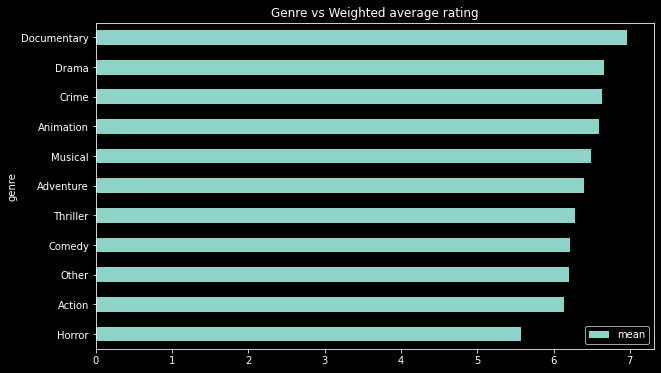

In [98]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
figsize = (10, 6)

result.plot(kind='barh', title='Genre vs Weighted average rating', figsize=figsize)

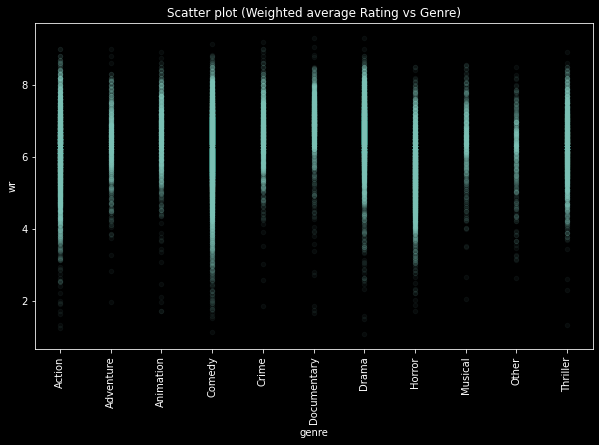

In [99]:
df.sort_values('genre').reset_index().plot(x='genre', y='wr', kind='scatter', alpha=0.05, rot=90,
                                           title='Scatter plot (Weighted average Rating vs Genre)', figsize=figsize)

# Q.2 Analysis

In [106]:
# Splits string of genres into a list of secondary and third genres.
# Or just the secondary if there are only 2 genres in the string.
# If there is only 1 genre in the string, then return empty list.
def split_series(series, genre):
  series_list = series.str.split(',')[0]
  if len(series_list) == 1:
    return ['empty', 'empty']
  elif len(series_list) == 2:
    series_list.remove(genre)
    return series_list + ['empty']
  else :
    series_list.remove(genre)
    return series_list

We select all movies with 'Horror' in "genres" string and split the genres into columns "genre_2" and "genre_3".

In [107]:
test_genre = 'Horror'
t = df[df['genres'].str.contains(test_genre)].copy()
t[['genre_2', 'genre_3']] = t[['genres']].apply(split_series, axis=1, result_type='expand', genre=test_genre)

We keep only those combination of genres with count > 10.

In [108]:
t = t[t.groupby('genres').genres.transform('count') >= 10].copy()

Prepare a pivot table for a heatmap

In [109]:
result_2 = t.pivot_table(index='genre_2',columns=['genre_3'],values='wr',aggfunc=['mean'])
result_2

mean                                                   \
genre_3     Adventure    Comedy     Crime     Drama   Fantasy    Music   
genre_2                                                                  
Action       5.173265  5.559638  5.810855  5.477097  5.545208      NaN   
Adventure         NaN  5.360721       NaN  5.642003  5.524841      NaN   
Comedy            NaN       NaN  6.096358  5.909084  5.656761  5.71579   
Crime             NaN       NaN       NaN  5.973700       NaN      NaN   
Documentary       NaN       NaN       NaN       NaN       NaN      NaN   
Drama             NaN       NaN       NaN       NaN  6.070420      NaN   
Fantasy           NaN       NaN       NaN       NaN       NaN      NaN   
Mystery           NaN       NaN       NaN       NaN       NaN      NaN   
Romance           NaN       NaN       NaN       NaN       NaN      NaN   
Sci-Fi            NaN       NaN       NaN       NaN       NaN      NaN   
Thriller          NaN       NaN       NaN       NaN       NaN      NaN   
empty             NaN       NaN       NaN       NaN       NaN      NaN   

                                                                         
genre_3       Musical   Mystery   Romance    Sci-Fi  Thriller     empty  
genre_2                                                                  
Action            NaN  5.327824       NaN  5.307485  5.235012  5.262162  
Adventure         NaN  5.780974       NaN  5.389366  5.347941  5.655394  
Comedy       5.957432  5.810013  5.902590  5.439793  5.519071  5.491912  
Crime             NaN  5.931561       NaN  5.611132  5.560461  5.895612  
Documentary       NaN       NaN       NaN       NaN       NaN  6.161793  
Drama             NaN  5.893081  5.959734  5.956317  5.713596  6.060925  
Fantasy           NaN  5.672774       NaN  5.632274  5.435060  5.710758  
Mystery           NaN       NaN  5.773533  5.627524  5.635438  5.708736  
Romance           NaN       NaN       NaN       NaN  5.251830       NaN  
Sci-Fi            NaN       NaN       NaN       NaN  5.374324  5.359928  
Thriller          NaN       NaN       NaN       NaN       NaN  5.352246  
empty             NaN       NaN       NaN       NaN       NaN  5.359968

# Q.2 Vizualize

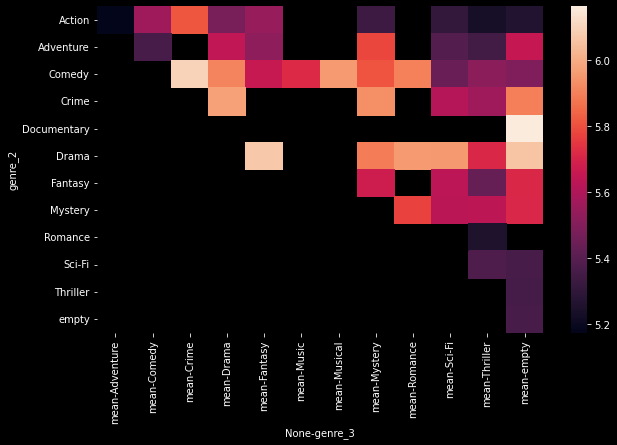

In [110]:
fig, ax = plt.subplots(figsize=figsize)  
sns.heatmap(result_2)

# Play

In [105]:
#@title Here we can try all sorts of weird genres combinations to find a movie for the evening watch
# 'Fantasy,Horror,Romance'
df[df['genres'] == 'Fantasy,Horror,Romance'].sort_values(['startYear'], ascending=False)

,tconst,titleType,primaryTitle,startYear,genres,averageRating,numVotes,genre,wr
253027,tt11116374,movie,Don't Kill Me,2021,"Fantasy,Horror,Romance",4.3,2073.0,Horror,4.939936
63571,tt0088851,movie,The Bride,1985,"Fantasy,Horror,Romance",5.4,3271.0,Horror,5.602885
49748,tt0068284,movie,Blacula,1972,"Fantasy,Horror,Romance",5.7,7147.0,Horror,5.769538
